<a href="https://colab.research.google.com/github/mathreatoeus/Boeing-X-Airbus-Identifier/blob/main/boeingXairbus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt   # plt.imshow()

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.oauth2.credentials import Credentials
from PIL import Image, UnidentifiedImageError


In [2]:
# Mounting the google drive into google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# helper function to load image and return it and input vector, adequate to the VGG16 net

def get_image(path):
  
    img = load_img(path, target_size=(224, 224))   # The input to VGG16 is a 224x224 RGB image

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return img, x

In [17]:
root = '/content/drive/MyDrive/Code/A320XB737/Datasets/'
# exclude = []
train_split, val_split = 0.75, 0.125

categories = [x[0] for x in os.walk(root) if x[0]][1:]   # [1:] = exclude the root directory itself
# categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/drive/MyDrive/Code/A320XB737/Datasets/Boeing_737', '/content/drive/MyDrive/Code/A320XB737/Datasets/Airbus_A320']


In [18]:
# Loading all the images from the root folder

data = []

for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except UnidentifiedImageError:
            print(f"Skipping image: {img_path}")

# count the number of classes
num_classes = len(categories)

Skipping image: /content/drive/MyDrive/Code/A320XB737/Datasets/Boeing_737/image_054.jpg
Skipping image: /content/drive/MyDrive/Code/A320XB737/Datasets/Boeing_737/image_084.jpg
Skipping image: /content/drive/MyDrive/Code/A320XB737/Datasets/Boeing_737/image_128.jpg


In [19]:
# Randomizing the data order

random.shuffle(data)

In [20]:
# Create training and validation (test split = 75%, 12.5%, 12.5%)

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [21]:
# Separating data for labels

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]


In [22]:
# normalize data

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_test.shape)

(37, 2)


In [23]:
# summary

print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 296 images from 2 categories
train / validation / test split: 222, 37, 37
training data shape:  (222, 224, 224, 3)
training labels shape:  (222, 2)


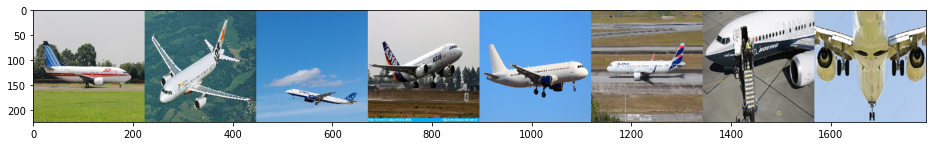

In [24]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [25]:
# Loading VGG16 and its weights
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [27]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=100, 
                         validation_data=(x_val, y_val))

Epoch 1/100
2/2 [==============================] - 149s 74s/step - loss: 1.0722 - accuracy: 0.5360 - val_loss: 0.9484 - val_accuracy: 0.4865
Epoch 2/100
2/2 [==============================] - 149s 74s/step - loss: 0.8993 - accuracy: 0.4865 - val_loss: 0.9878 - val_accuracy: 0.5135
Epoch 3/100
2/2 [==============================] - 166s 93s/step - loss: 0.9454 - accuracy: 0.5270 - val_loss: 0.7338 - val_accuracy: 0.5135
Epoch 4/100
2/2 [==============================] - 146s 74s/step - loss: 0.7317 - accuracy: 0.4910 - val_loss: 0.8236 - val_accuracy: 0.4865
Epoch 5/100
2/2 [==============================] - 147s 74s/step - loss: 0.8430 - accuracy: 0.4685 - val_loss: 0.7062 - val_accuracy: 0.5405
Epoch 6/100
2/2 [==============================] - 146s 72s/step - loss: 0.7222 - accuracy: 0.5045 - val_loss: 0.8377 - val_accuracy: 0.5135
Epoch 7/100
2/2 [==============================] - 147s 75s/step - loss: 0.7954 - accuracy: 0.5270 - val_loss: 0.7288 - val_accuracy: 0.5405
Epoch 8/100
2

In [1]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["loss"])
ax2.set_title("Training Loss")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

NameError: ignored